In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
import nilearn
from nilearn.plotting import plot_stat_map, plot_glass_brain
import pickle
import json
from typing import Dict, List, Tuple
from tqdm import tqdm
import warnings
from scipy import stats
from scipy.stats import sem
warnings.filterwarnings('ignore')

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter1d

# Set style for all plots
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 6,
    'xtick.labelsize': 6,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "00_final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

N_STATES_RANGE = range(2, 20)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#4daf4a',    # Green
    'paranoia_light': '#90ee90', # Light green
    'combined': '#984ea3',    # Purple
    'combined_light': '#d8b2d8' # Light purple
}

In [4]:
def save_figure(fig, save_dir, filename, dpi=300, bbox_inches='tight'):
    # Remove any existing file extension from the filename
    base_filename = Path(filename).stem
    
    # Save both PNG and SVG versions
    fig.savefig(Path(save_dir) / f'{base_filename}.png', dpi=dpi, bbox_inches=bbox_inches)
    fig.savefig(Path(save_dir) / f'{base_filename}.svg', dpi=dpi, bbox_inches=bbox_inches)
    plt.close(fig)

In [5]:
SAVE_DIR_FIG2 = Path(SAVE_DIR) / "figure2"
SAVE_DIR_FIG2.mkdir(parents=True, exist_ok=True)

In [9]:
def load_data(group: str, n_state: int) -> Dict:
    """Load both metrics and summary files."""
    base_path = OUTPUT_DIR / f"04_{group}_hmm_{n_state}states_ntw_native_trimmed" / "statistics"
    
    # Load metrics
    metrics_path = base_path / f"{group}_metrics.pkl"
    try:
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
    except Exception as e:
        print(f"Error loading metrics for {group}, n_state={n_state}: {e}")
        metrics = None
    
    # Load summary
    summary_path = base_path / f"{group}_summary.json"
    try:
        with open(summary_path, 'r') as f:
            summary = json.load(f)
    except Exception as e:
        print(f"Error loading summary for {group}, n_state={n_state}: {e}")
        summary = None
    
    sequence_path = base_path / f"{group}_state_sequences.npy"
    try:
        sequences = np.load(sequence_path)
    except Exception as e:
        print(f"Error loading sequences for {group}, n_state={n_state}: {e}")
        sequences = None
    
    return {'metrics': metrics, 'summary': summary, 'sequences': sequences}

def extract_model_metrics(data: Dict) -> Dict:
    """Extract relevant metrics from both metrics and summary files."""
    metrics = {}
    
    try:
        metrics_data = data['metrics']
        summary_data = data['summary']
        
        if metrics_data:
            # Get state frequencies and calculate percentage below threshold
            state_freq_mean = metrics_data['subject_consistency']['summary']['state_frequency']['mean']
            metrics['pct_low_freq'] = np.mean(state_freq_mean < 0.1) * 100
            
            # Get pattern correlations variance
            pattern_corr = metrics_data['subject_consistency']['pattern_correlation']
            state_variances = np.var(pattern_corr, axis=0)
            metrics['max_pattern_var'] = np.max(state_variances)
            
            # Get mean pattern stability
            state_props = metrics_data['state_properties']
            pattern_stabilities = []
            for key in state_props.keys():
                if isinstance(key, (int, str)) and key != 'separability':
                    if isinstance(key, str) and key.isdigit():
                        key = int(key)
                    pattern_stabilities.append(state_props[key]['pattern_stability'])
            metrics['mean_pattern_stability'] = np.mean(pattern_stabilities)
        
        if summary_data:
            # Extract BIC and log-likelihood
            metrics['bic'] = summary_data['model_performance']['bic']
            metrics['log_likelihood'] = summary_data['model_performance']['log_likelihood']
        
    except Exception as e:
        print(f"Error extracting metrics: {e}")
        return None
        
    return metrics

In [10]:
def create_selection_plot(groups=['affair', 'paranoia']):
    """Create model selection plot showing percentage of reliable states."""
    # Create figure with a single plot
    fig, ax = plt.subplots(figsize=(7, 2))
    
    # Define markers for each group
    markers = {
        'affair': 'o',      # Circle
        'paranoia': 's',    # Square
        'combined': '^'     # Triangle
    }
    
    for group in groups:
        metrics_data = []
        
        for n_state in N_STATES_RANGE:
            data = load_data(group, n_state)
            if data:
                metrics = extract_model_metrics(data)
                if metrics:
                    metrics['n_states'] = n_state
                    metrics_data.append(metrics)
        
        if metrics_data:
            df = pd.DataFrame(metrics_data)
            
            # Plot reliable states percentage
            ax.plot(df['n_states'], 100-df['pct_low_freq'], 
                   color=COLORS[group], 
                   label=f'{group.capitalize()}',
                   marker=markers[group],
                   markersize=4,
                   linewidth=2,
                   alpha=0.7)
    
    # Set x-axis to show all integer values
    ax.set_xticks(list(N_STATES_RANGE))
    
    # Add vertical lines at n_state=3,4
    ax.axvline(x=3, color='gray', linestyle=':', alpha=0.8)
    ax.axvline(x=4, color='gray', linestyle=':', alpha=0.8)
    
    # Labels and titles
    # ax.set_title('Model Selection: Reliable States')
    ax.set_xlabel('Number of States')
    ax.set_ylabel('% Reliable States')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    save_figure(fig, SAVE_DIR_FIG2, f'model_selection_{"_".join(groups)}')

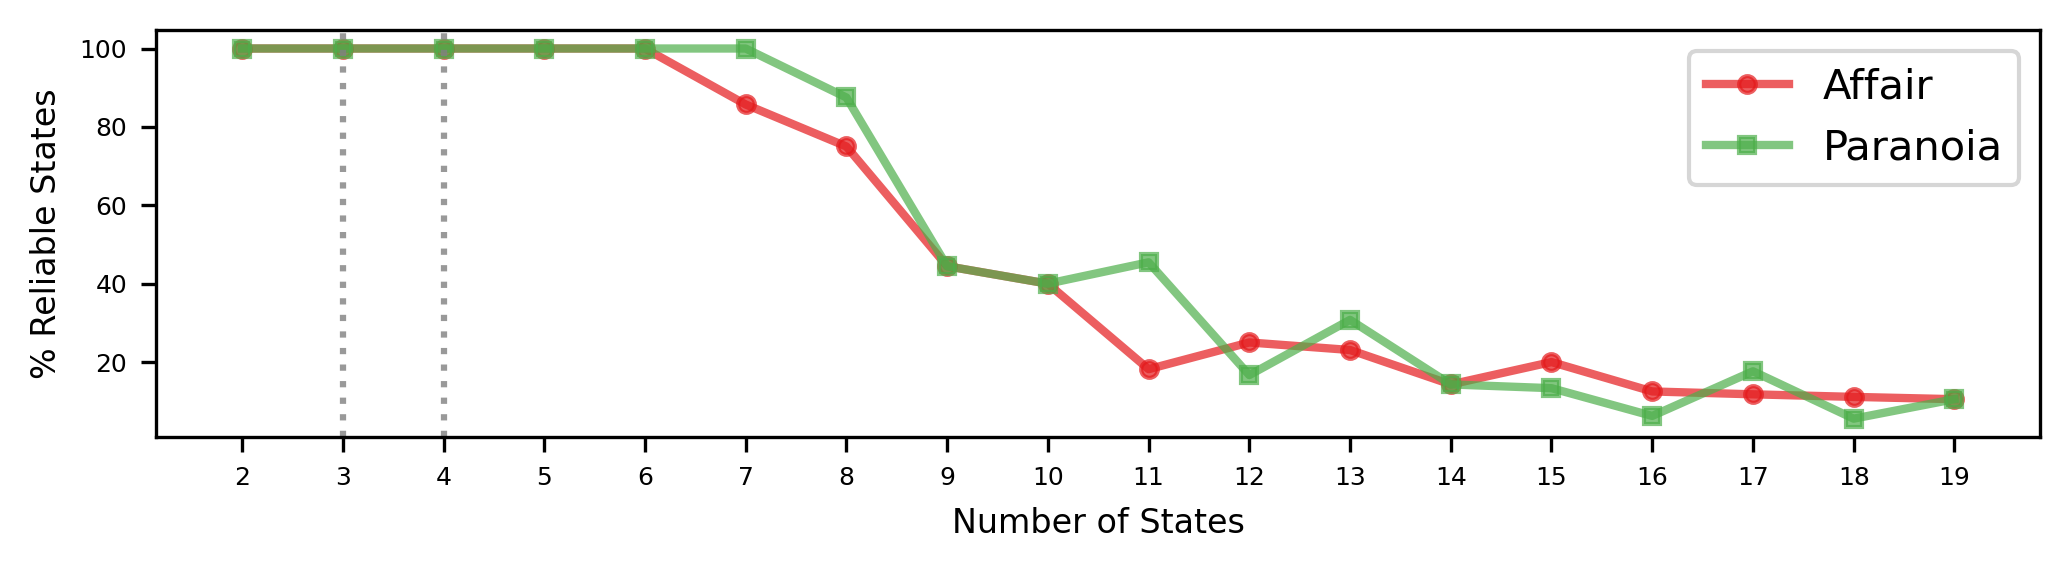

In [11]:
create_selection_plot(groups=['affair', 'paranoia'])

In [13]:
def plot_state_consistency(n_states=[3, 4], groups=['affair', 'paranoia'], figsize=(7, 3)):
    """
    Plot state pattern consistency across subjects.
    
    Args:
        n_states: List of state counts to compare
        groups: List of group names
    """
    # Create a single row of subplots with the specified order
    fig, axes = plt.subplots(1, len(n_states) * len(groups), figsize=figsize, sharey=True)
    
    # Stats collection
    all_stats = []
    
    # Plot index counter
    plot_idx = 0
    
    # Process in the specific order: affair (3), affair (4), paranoia (3), paranoia (4)
    for group in groups:
        for n_state in n_states:
            # Load data
            data = load_data(group, n_state)
            
            if not data or not data['metrics'] or 'subject_consistency' not in data['metrics']:
                axes[plot_idx].text(0.5, 0.5, "No data available", ha='center', va='center')
                plot_idx += 1
                continue
            
            # Get pattern correlations
            if 'pattern_correlation' in data['metrics']['subject_consistency']:
                pattern_corr = data['metrics']['subject_consistency']['pattern_correlation']
                
                # Check if shape is (subjects, states)
                if len(pattern_corr.shape) == 2 and pattern_corr.shape[1] == n_state:
                    # Each subject's correlation with state patterns
                    n_subjects = pattern_corr.shape[0]
                    
                    # For each state, get subject correlations
                    for state in range(n_state):
                        state_corrs = pattern_corr[:, state]
                        
                        # For stats
                        low_corr_count = sum(1 for c in state_corrs if c < 0.7)
                        all_stats.append({
                            'Group': group.capitalize(),
                            'States': n_state,
                            'State': state,
                            'Mean Correlation': np.mean(state_corrs),
                            'Below Threshold': low_corr_count,
                            'Total Subjects': n_subjects,
                            'Percent Below': (low_corr_count/n_subjects)*100
                        })
                    
                    # Create boxplot for this group/state count
                    ax = axes[plot_idx]
                    
                    # Prepare data in format for boxplot
                    plot_data = pd.DataFrame(
                        pattern_corr, 
                        columns=[f"State {s+1}" for s in range(n_state)]
                    )
                    
                    # Create boxplot WITHOUT fliers (outliers)
                    sns.boxplot(data=plot_data, ax=ax, color=COLORS[group], width=0.5, fliersize=0)
                    
                    # Add individual points
                    for k in range(n_state):
                        # Jitter x positions
                        x = np.random.normal(k, 0.05, size=n_subjects)
                        ax.scatter(x, pattern_corr[:, k], alpha=0.8, s=6, 
                                color='black', marker='o')
                    
                    # Titles and labels
                    ax.set_title(f"{group.capitalize()} ({n_state} States)")
                    if plot_idx == 0:
                        ax.set_ylabel("Subject-State Pattern Correlation")
                    ax.set_ylim(0, 1)
                    
                else:
                    axes[plot_idx].text(0.5, 0.5, 
                                  f"Unexpected matrix shape: {pattern_corr.shape}",
                                  ha='center', va='center')
            else:
                axes[plot_idx].text(0.5, 0.5, "No correlation data", ha='center', va='center')
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()
    save_figure(fig, SAVE_DIR_FIG2, f'subject_state_consistency_{"_".join(groups)}')
    plt.close()

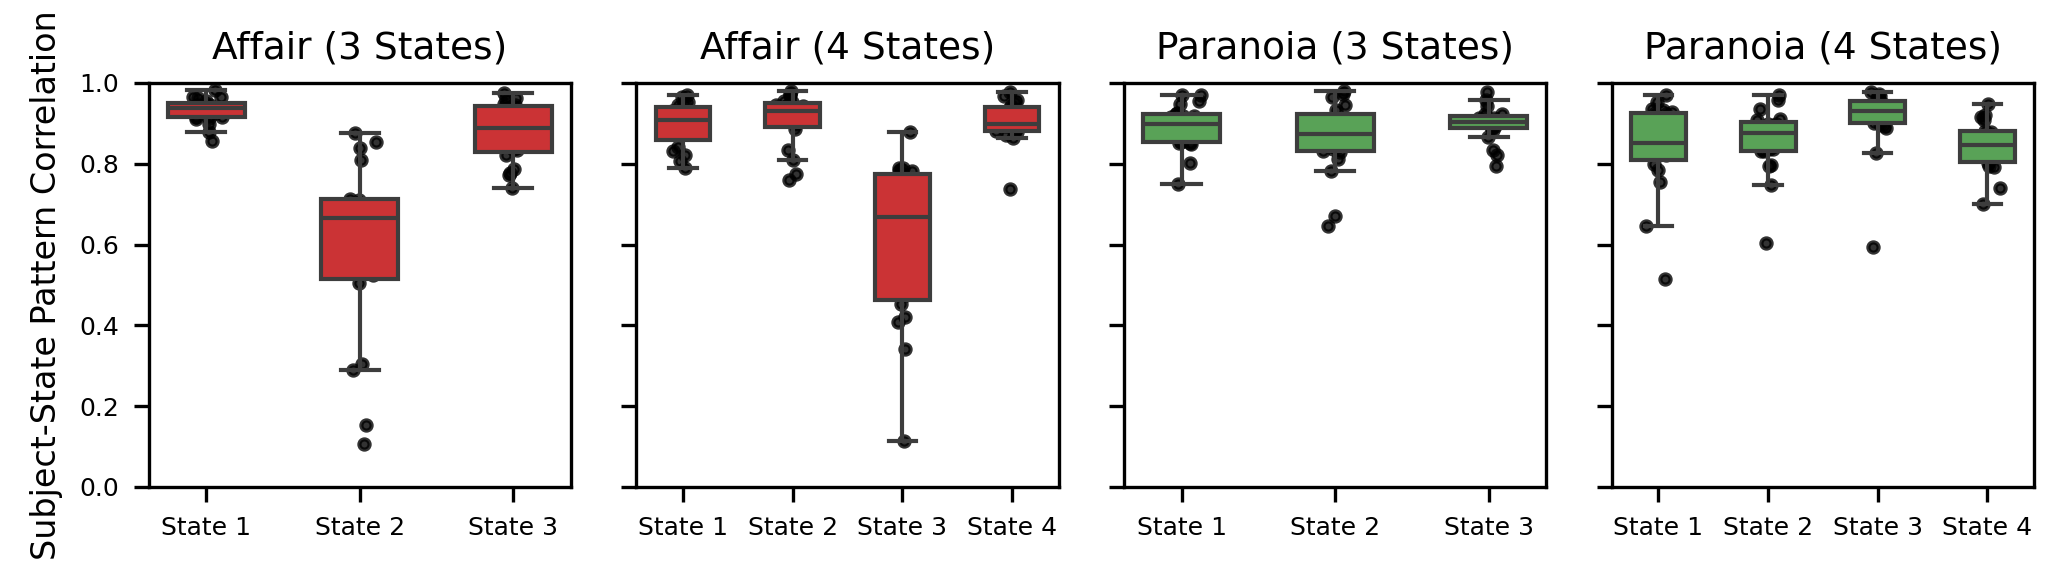

In [14]:
plot_state_consistency(n_states=[3, 4], groups=['affair', 'paranoia'], figsize=(7, 2))

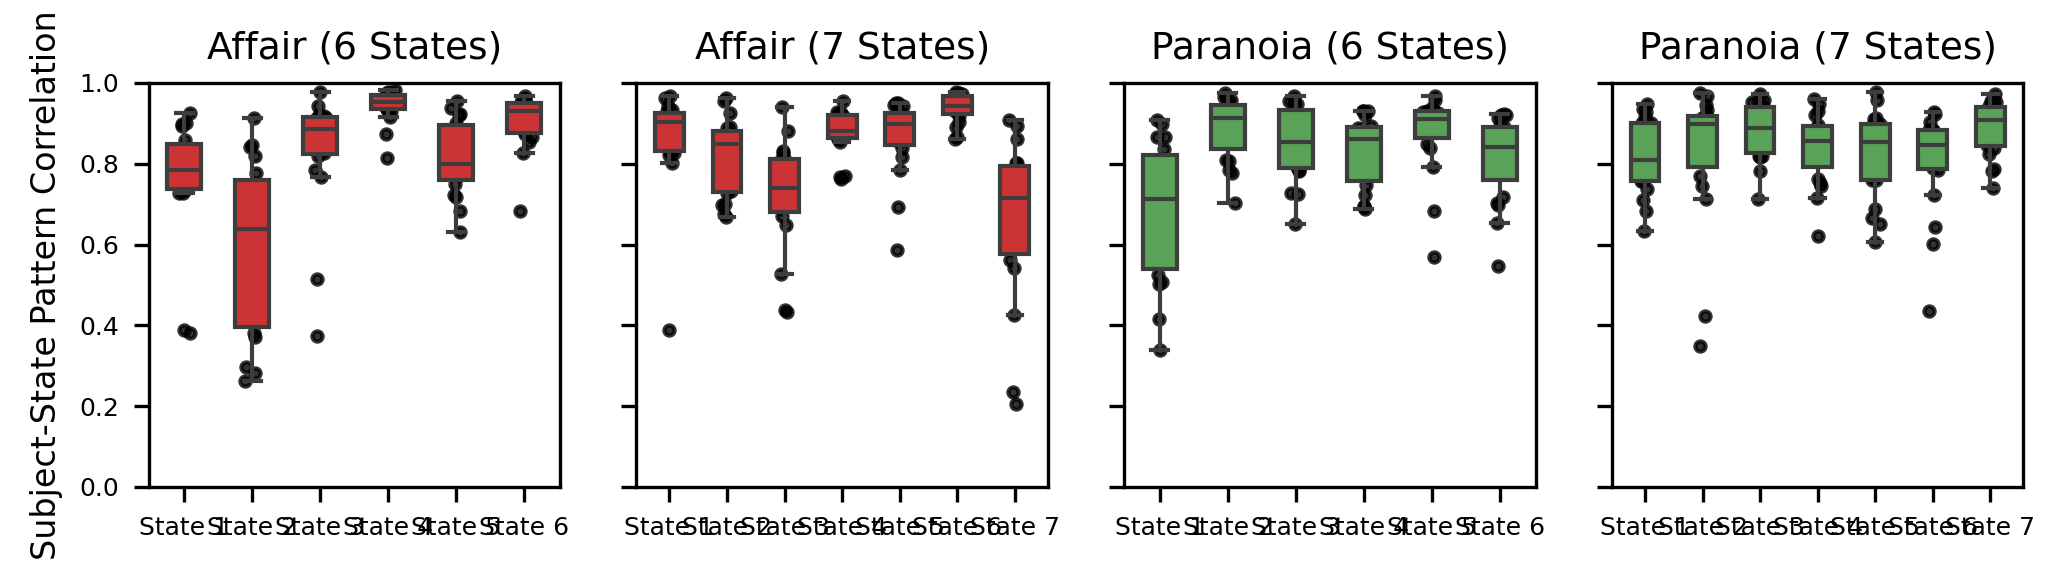

In [15]:
plot_state_consistency(n_states=[6, 7], groups=['affair', 'paranoia'], figsize=(7, 2))

## sequence plot

In [8]:
affair_sequences = load_data('affair', 3)['sequences']
paranoia_sequences = load_data('paranoia', 3)['sequences']




In [63]:
def plot_brain_state_sequences(state_sequences, cmap='viridis', figsize=(4, 2), 
                              title="Brain State Sequences", save_path=None,
                              group='affair', state_mapping=None):
    """
    Plot brain state sequences as color-coded bars with no gaps between subjects.
    
    Parameters:
    -----------
    state_sequences : numpy.ndarray
        Array of shape (n_subjects, n_timepoints) containing state labels (0, 1, 2)
    cmap : str or matplotlib.colors.Colormap
        Colormap to use for the states
    figsize : tuple
        Figure size (width, height)
    title : str
        Plot title
    save_path : str, optional
        Path to save the figure
    group : str
        Which group the data belongs to ('affair' or 'paranoia')
    state_mapping : dict, optional
        Dictionary mapping states between groups
    """
    n_subjects, n_timepoints = state_sequences.shape
    
    # Create a copy of the state sequences to avoid modifying the original
    mapped_sequences = state_sequences.copy()
    
    # Apply state mapping if needed
    if state_mapping is not None and group == 'paranoia':
        # For paranoia group, directly map the state values using paranoia_to_affair mapping
        for i in range(n_subjects):
            for t in range(n_timepoints):
                original_state = state_sequences[i, t]
                # Use the correct mapping direction: paranoia_to_affair
                mapped_sequences[i, t] = state_mapping['paranoia_to_affair'].get(original_state, original_state)
    
    # Get the number of unique states after mapping
    n_states = len(np.unique(mapped_sequences))
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colors for each state
    if isinstance(cmap, str):
        if cmap == 'categorical':
            # Use distinct colors for categorical data
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
            cmap = mcolors.ListedColormap(colors[:n_states])
        else:
            cmap = plt.get_cmap(cmap, n_states)
    
    # Plot the grid using imshow
    im = ax.imshow(mapped_sequences, aspect='auto', cmap=cmap, 
                  interpolation='nearest', origin='lower',
                  extent=[0, n_timepoints-1, -0.5, n_subjects-0.5])
    
    # Set axis limits
    ax.set_xlim(0, n_timepoints-1)
    ax.set_ylim(-0.5, n_subjects-0.5)
    
    # Add labels and title
    # ax.set_xlabel('Time Points')
    # ax.set_ylabel('Subject')
    # ax.set_title(title)
    
    # Add y-ticks for each subject
    ax.set_yticks(np.arange(n_subjects))
    ax.set_yticklabels([f'{i+1}' for i in range(n_subjects)])
    
    # Add colorbar
    # cbar = plt.colorbar(im, ax=ax, ticks=np.arange(n_states))
    # cbar.set_label('Brain State')
    
    # Set colorbar labels
    # cbar.set_ticklabels([f'State {i}' for i in range(n_states)])
    
    plt.tight_layout()
    plt.show()
    plt.close()
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

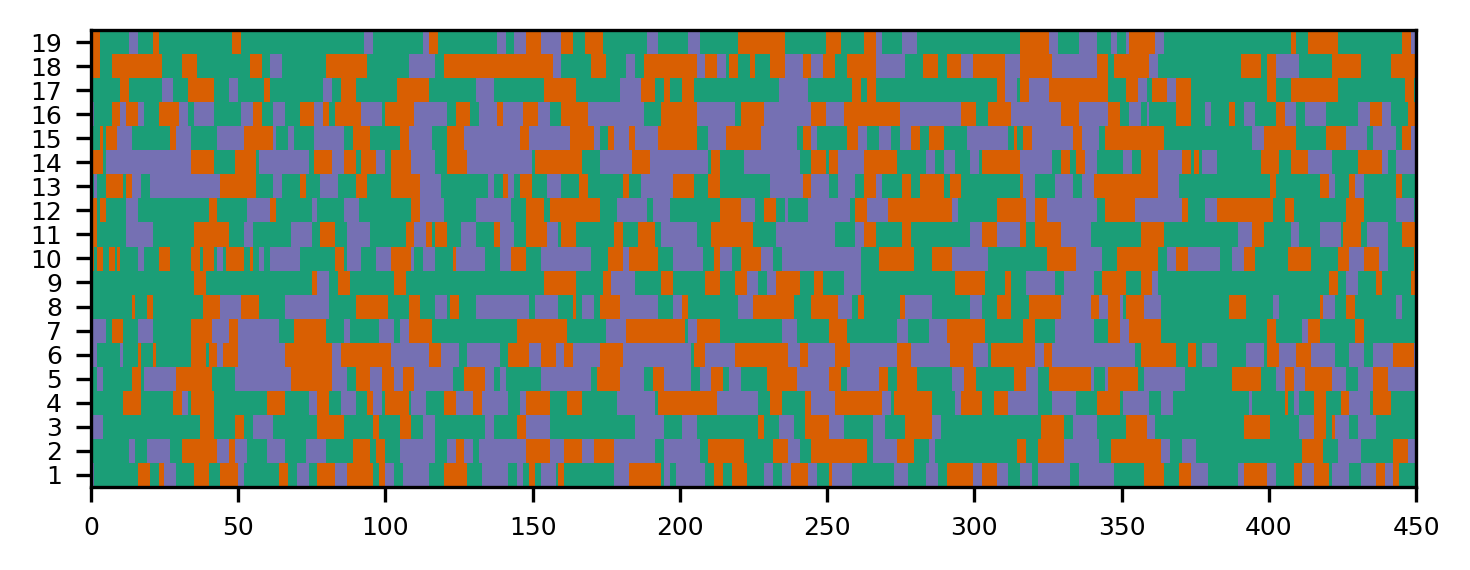

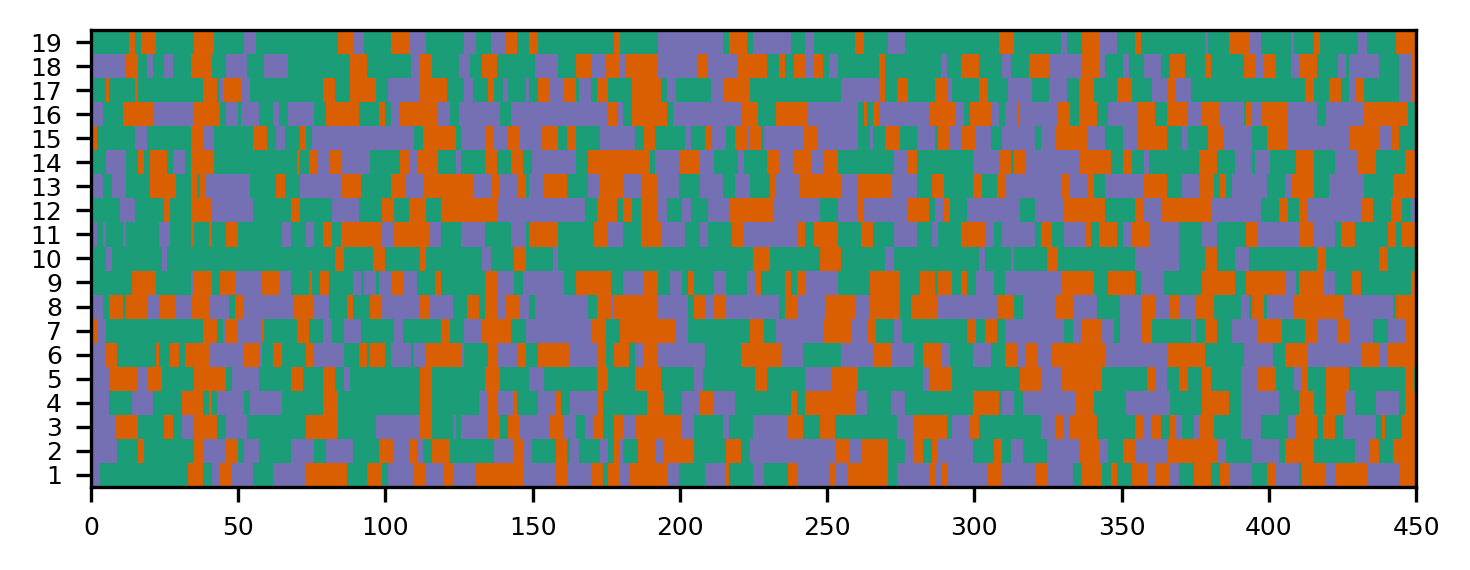

In [65]:
# State mapping
state_mapping = {
    'affair_to_paranoia': {0: 1, 1: 2, 2: 0},
    'paranoia_to_affair': {1: 0, 2: 1, 0: 2}
}

# Define a consistent colormap
custom_cmap = mcolors.ListedColormap(['#1b9e77', '#d95f02', '#7570b3'])

# Plot affair group
fig_affair, ax_affair = plot_brain_state_sequences(
    affair_sequences,
    cmap=custom_cmap,
    figsize=(5, 2),
    title="",
    group='affair',
    state_mapping=state_mapping
)

# Plot paranoia group with consistent colors
fig_paranoia, ax_paranoia = plot_brain_state_sequences(
    paranoia_sequences,
    cmap=custom_cmap,
    figsize=(5, 2),
    title="",
    group='paranoia',
    state_mapping=state_mapping
)

In [67]:
def plot_state_probabilities(state_sequences, figsize=(3, 1), 
                            title="Probability of state expression over time",
                            colors=None, save_path=None, 
                            group='affair', state_mapping=None):
    """
    Create a stacked area plot showing probability of each state over time.
    
    Parameters:
    -----------
    state_sequences : numpy.ndarray
        Array of shape (n_subjects, n_timepoints) containing state labels (0, 1, 2)
    figsize : tuple
        Figure size (width, height)
    title : str
        Plot title
    colors : list, optional
        List of colors for each state
    save_path : str, optional
        Path to save the figure
    group : str
        Which group the data belongs to ('affair' or 'paranoia')
    state_mapping : dict, optional
        Dictionary mapping states between groups
    """
    n_subjects, n_timepoints = state_sequences.shape
    n_states = len(np.unique(state_sequences))
    
    # Define colors if not provided
    if colors is None:
        colors = ['#1b9e77', '#d95f02', '#7570b3']  # ColorBrewer colors
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate probability of each state at each timepoint
    state_probs = np.zeros((n_states, n_timepoints))
    
    # Apply mapping if provided
    if state_mapping is not None and group == 'paranoia':
        # For paranoia group, directly use the paranoia_to_affair mapping
        paranoia_to_affair = state_mapping['paranoia_to_affair']
        
        # Calculate probabilities with the mapping applied
        for t in range(n_timepoints):
            for paranoia_state in range(n_states):
                # Map the paranoia state to the corresponding affair state
                affair_state = paranoia_to_affair.get(paranoia_state, paranoia_state)
                # Add the probability to the corresponding affair state position
                state_probs[affair_state, t] = np.mean(state_sequences[:, t] == paranoia_state)
    else:
        # For affair group or if no mapping provided, use states as-is
        for t in range(n_timepoints):
            for s in range(n_states):
                state_probs[s, t] = np.mean(state_sequences[:, t] == s)
    
    # Create x-axis values
    x = np.arange(n_timepoints)
    
    # Create stacked area plot
    ax.stackplot(x, state_probs, labels=[f'#{i+1}' for i in range(n_states)], 
                colors=colors, alpha=0.9)
    
    # Add labels and title
    # ax.set_xlabel('Time')
    # ax.set_ylabel('Probability')
    # ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Set axis limits
    ax.set_xlim(0, n_timepoints-1)
    ax.set_ylim(0, 1)
    
    # Add grid
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

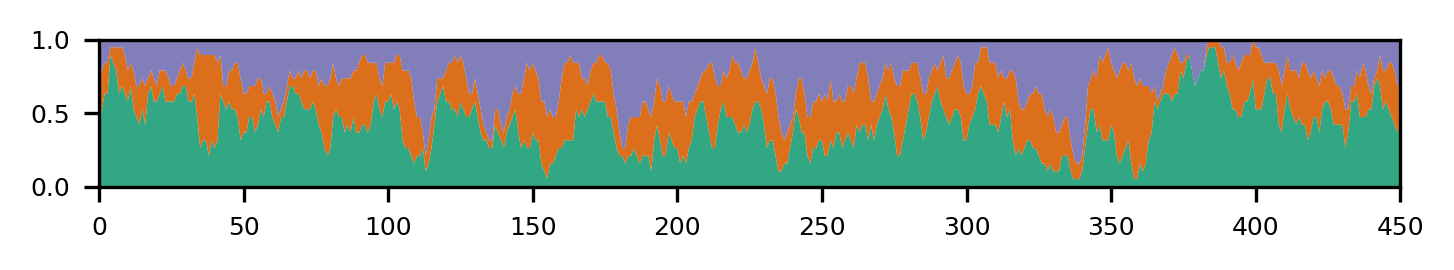

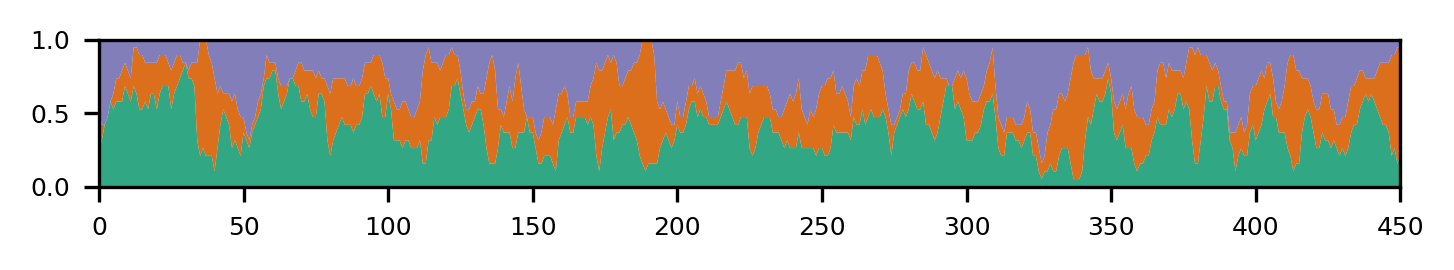

In [69]:
# State mapping
state_mapping = {
    'affair_to_paranoia': {0: 1, 1: 2, 2: 0},
    'paranoia_to_affair': {1: 0, 2: 1, 0: 2}
}

# Define consistent colors for all states
state_colors = ['#1b9e77', '#d95f02', '#7570b3']  # Teal, orange, purple

# Plot affair group
fig_affair, ax_affair = plot_state_probabilities(
    affair_sequences,
    figsize=(5, 1),
    title="",
    colors=state_colors,
    group='affair',
    state_mapping=state_mapping
)

# Plot paranoia group with consistent colors
fig_paranoia, ax_paranoia = plot_state_probabilities(
    paranoia_sequences,
    figsize=(5, 1),
    title="",
    colors=state_colors,
    group='paranoia',
    state_mapping=state_mapping
)

## Supplementary figures

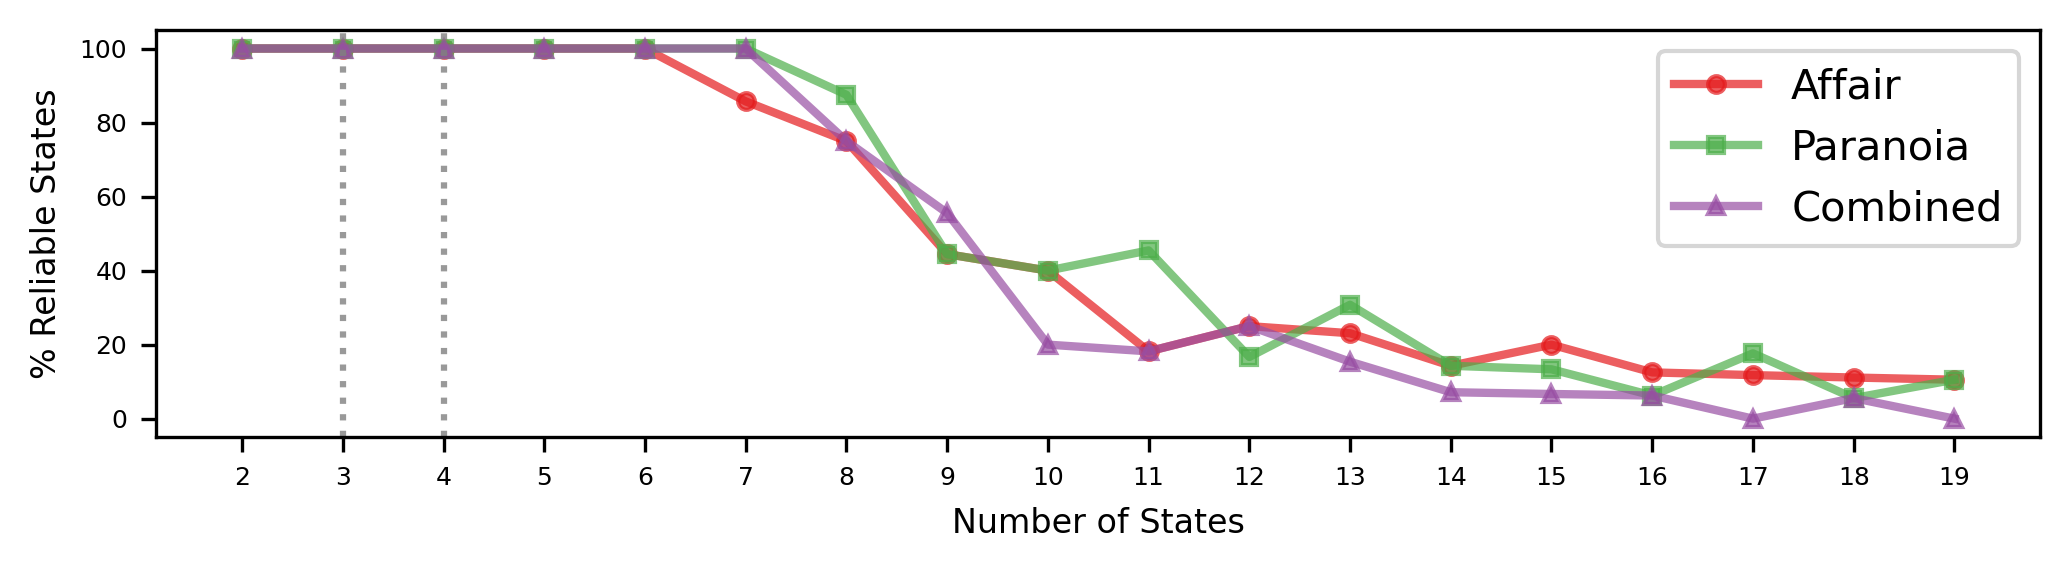

In [12]:
create_selection_plot(groups=['affair', 'paranoia', 'combined'])

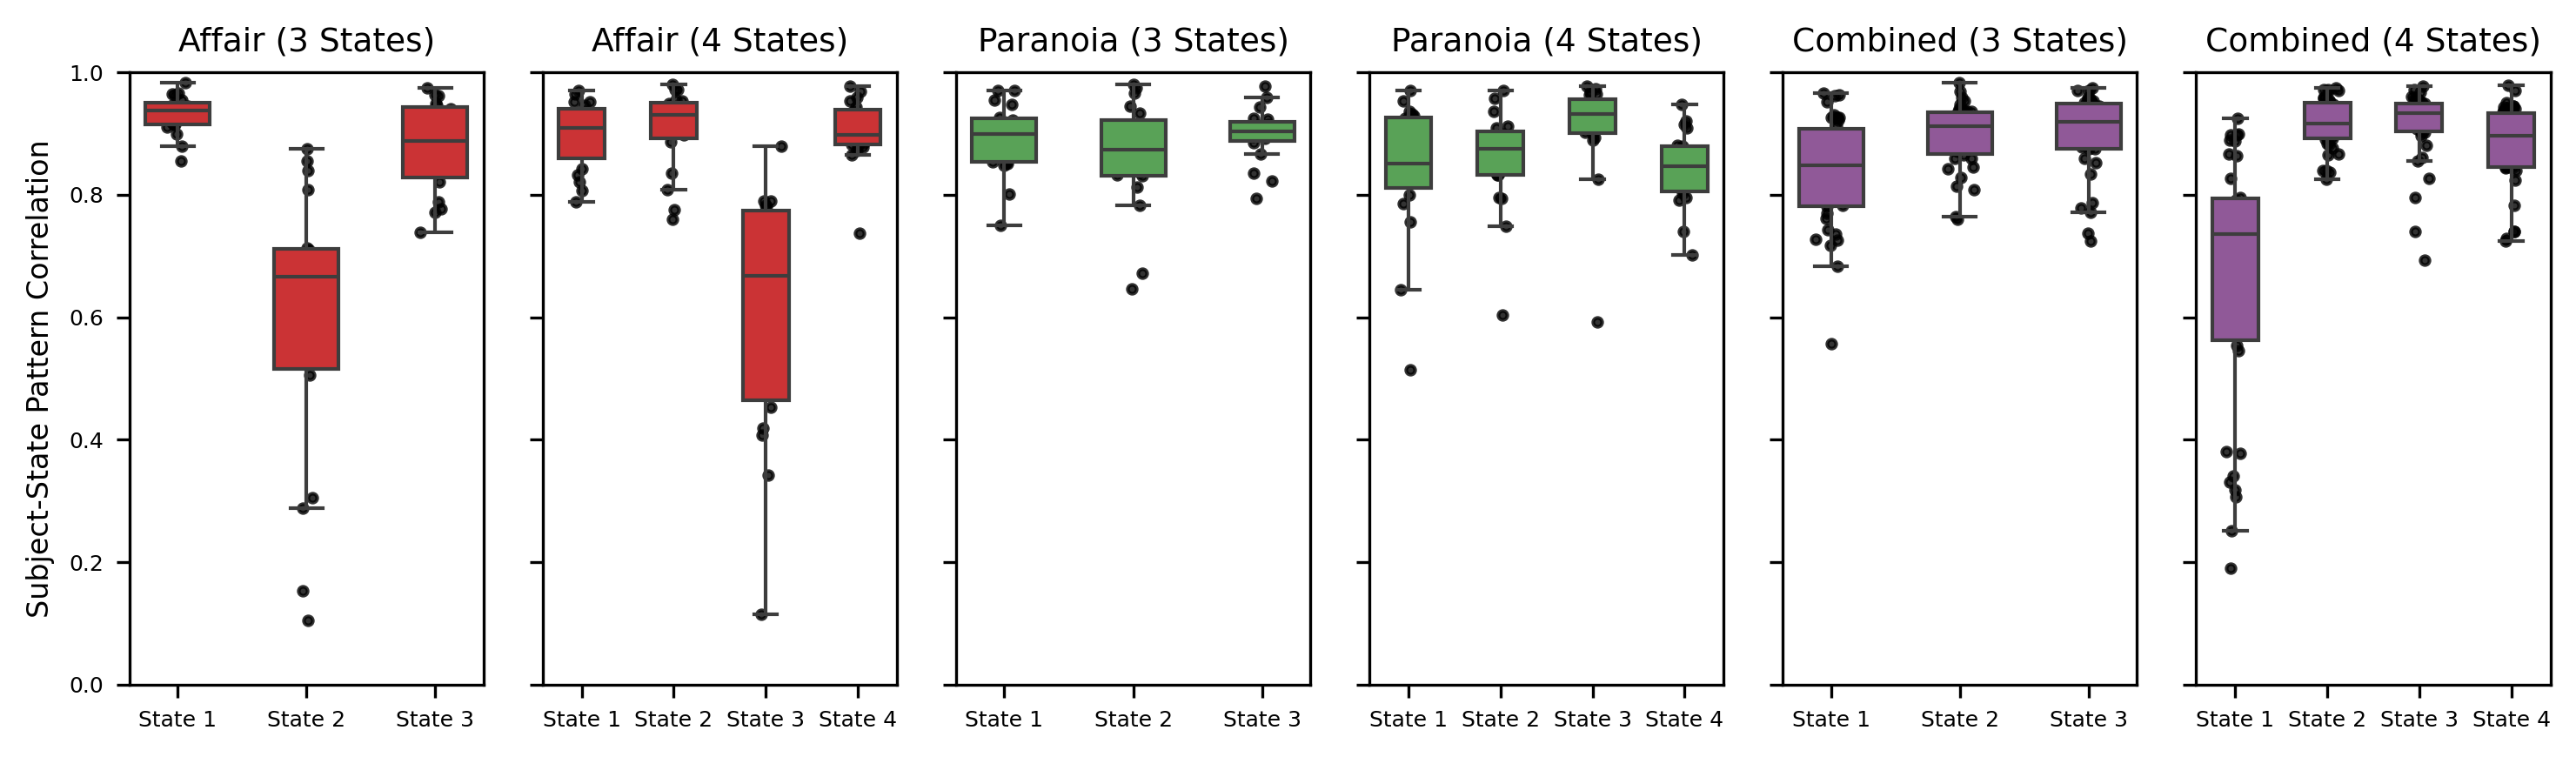

In [16]:
plot_state_consistency(n_states=[3, 4], groups=['affair', 'paranoia', 'combined'], figsize=(10, 3))

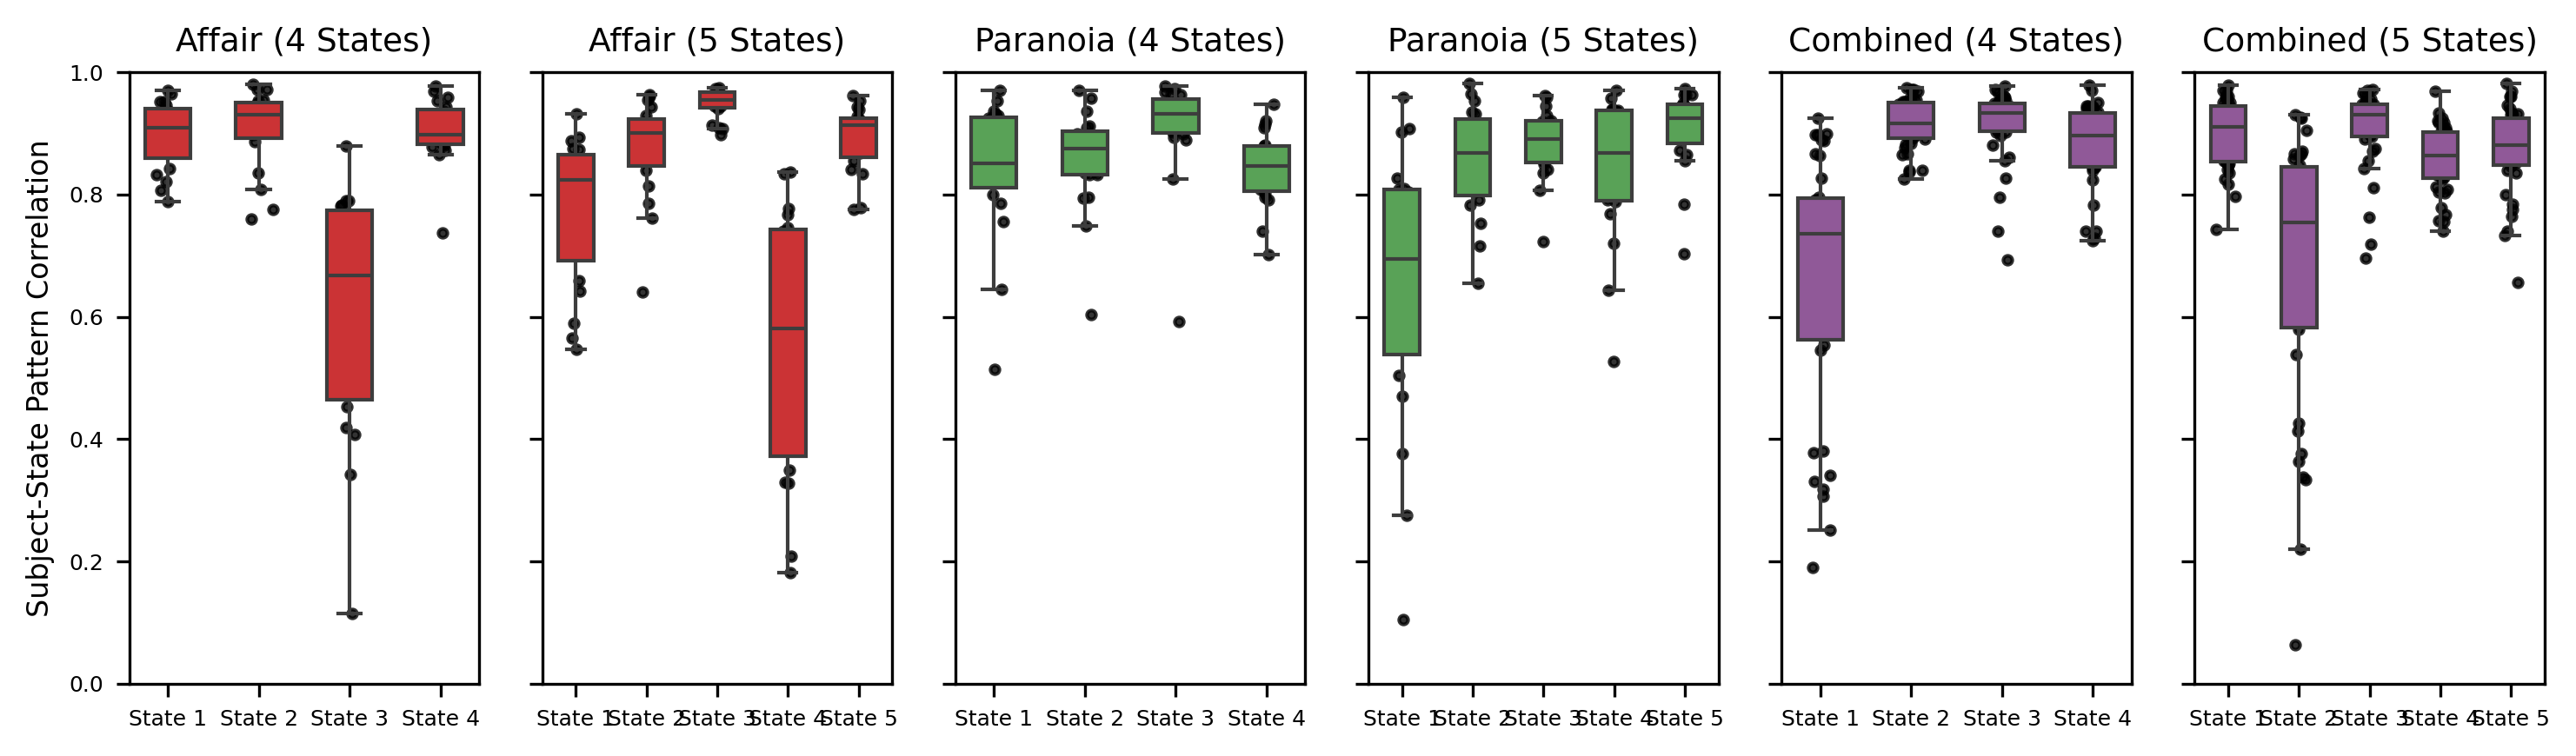

In [18]:
plot_state_consistency(n_states=[4, 5], groups=['affair', 'paranoia', 'combined'], figsize=(10, 3))

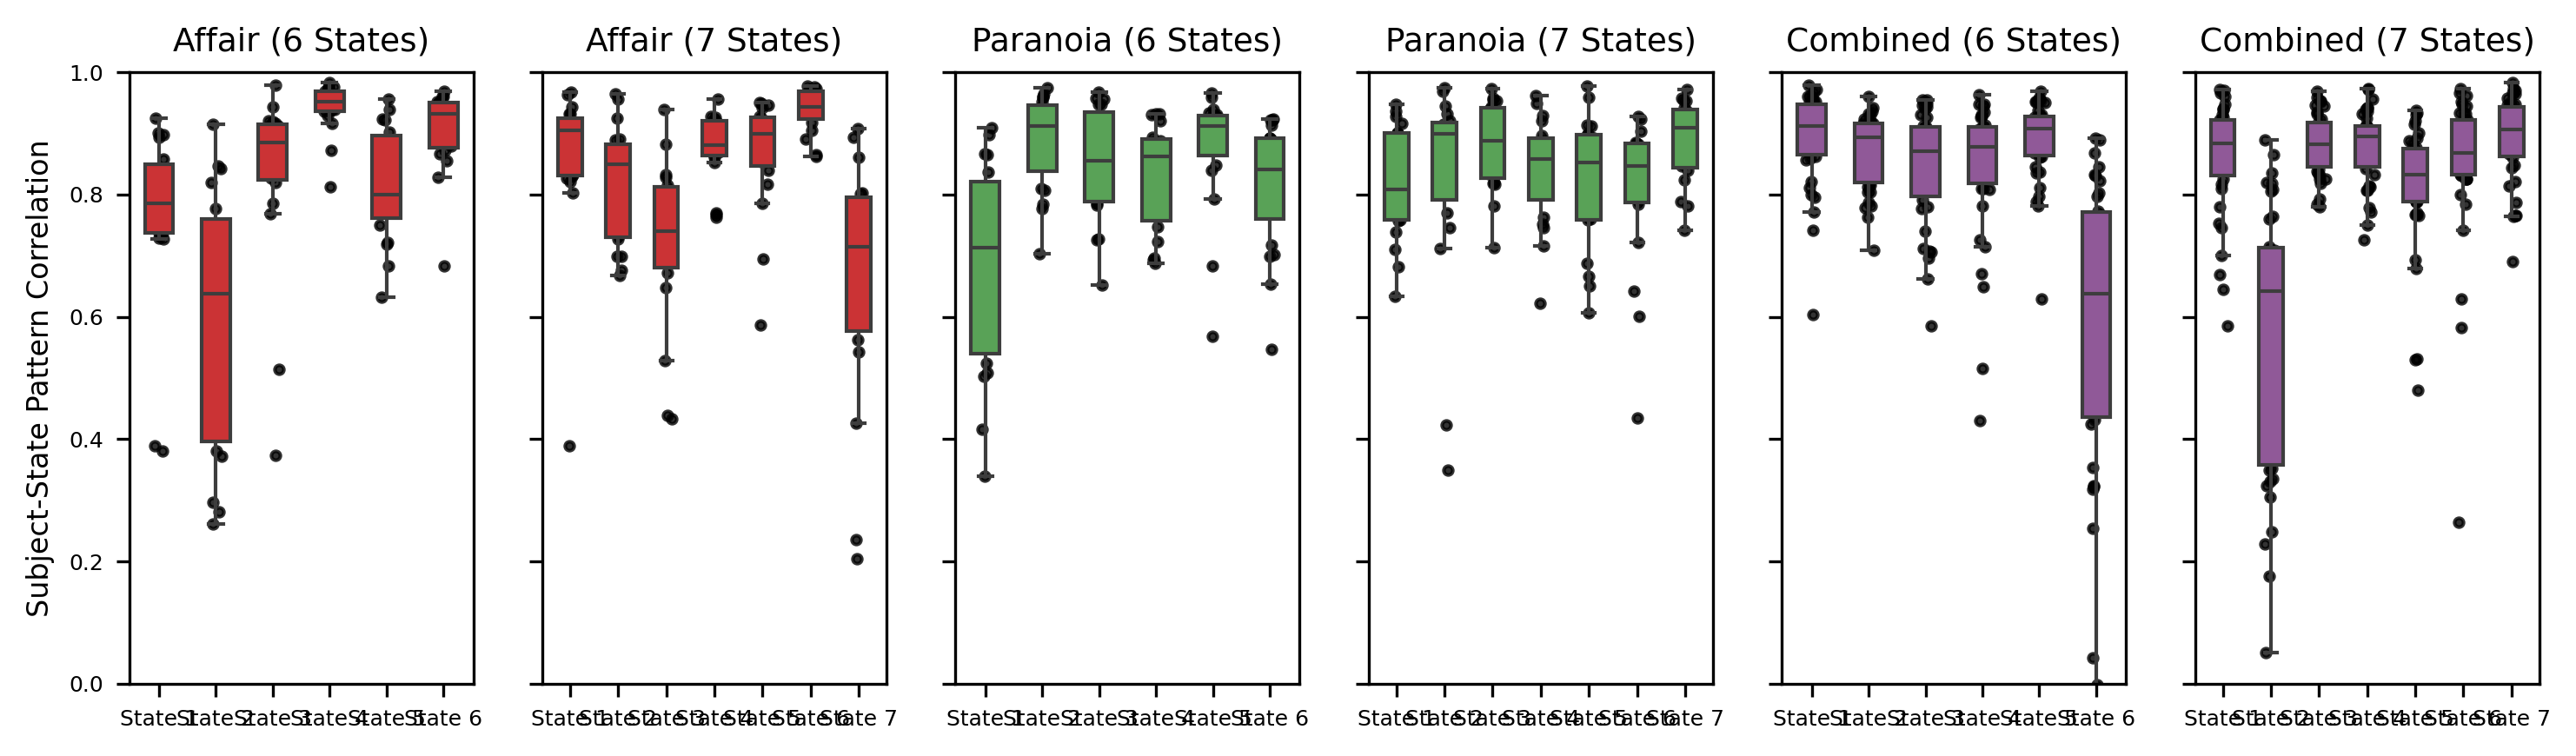

In [17]:
plot_state_consistency(n_states=[6, 7], groups=['affair', 'paranoia', 'combined'], figsize=(10, 3))